In [1]:
import scvelo as scv
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# scv.logging.print_version()

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
scv.set_figure_params()
sc.settings.figdir = "../figures"
scv.settings.figdir = "../figures"

# Merging loom file to get the layers

In [5]:
ldata = scv.read('../data/sample_alignments_DMIWJ.loom')

In [6]:
cdata = sc.read_10x_h5('../data/sample_filtered_feature_bc_matrix.h5', genome=None, gex_only=True, backup_url=None)

In [7]:
cdata

AnnData object with n_obs × n_vars = 6549 × 18082
    var: 'gene_ids', 'feature_types', 'genome'

In [8]:
adata = scv.utils.merge(cdata, ldata)

In [9]:
adata

AnnData object with n_obs × n_vars = 6549 × 18082
    obs: 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [10]:
adata.layers['spliced']

<6549x18082 sparse matrix of type '<class 'numpy.uint32'>'
	with 227251 stored elements in Compressed Sparse Row format>

In [11]:
adata.layers['unspliced']

<6549x18082 sparse matrix of type '<class 'numpy.uint32'>'
	with 847326 stored elements in Compressed Sparse Row format>

# scRNA-seq Preprocessing

# QC

In [12]:
# Identify mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('mt-')

In [13]:
# Basic QC
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

In [14]:
adata

AnnData object with n_obs × n_vars = 6549 × 18082
    obs: 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

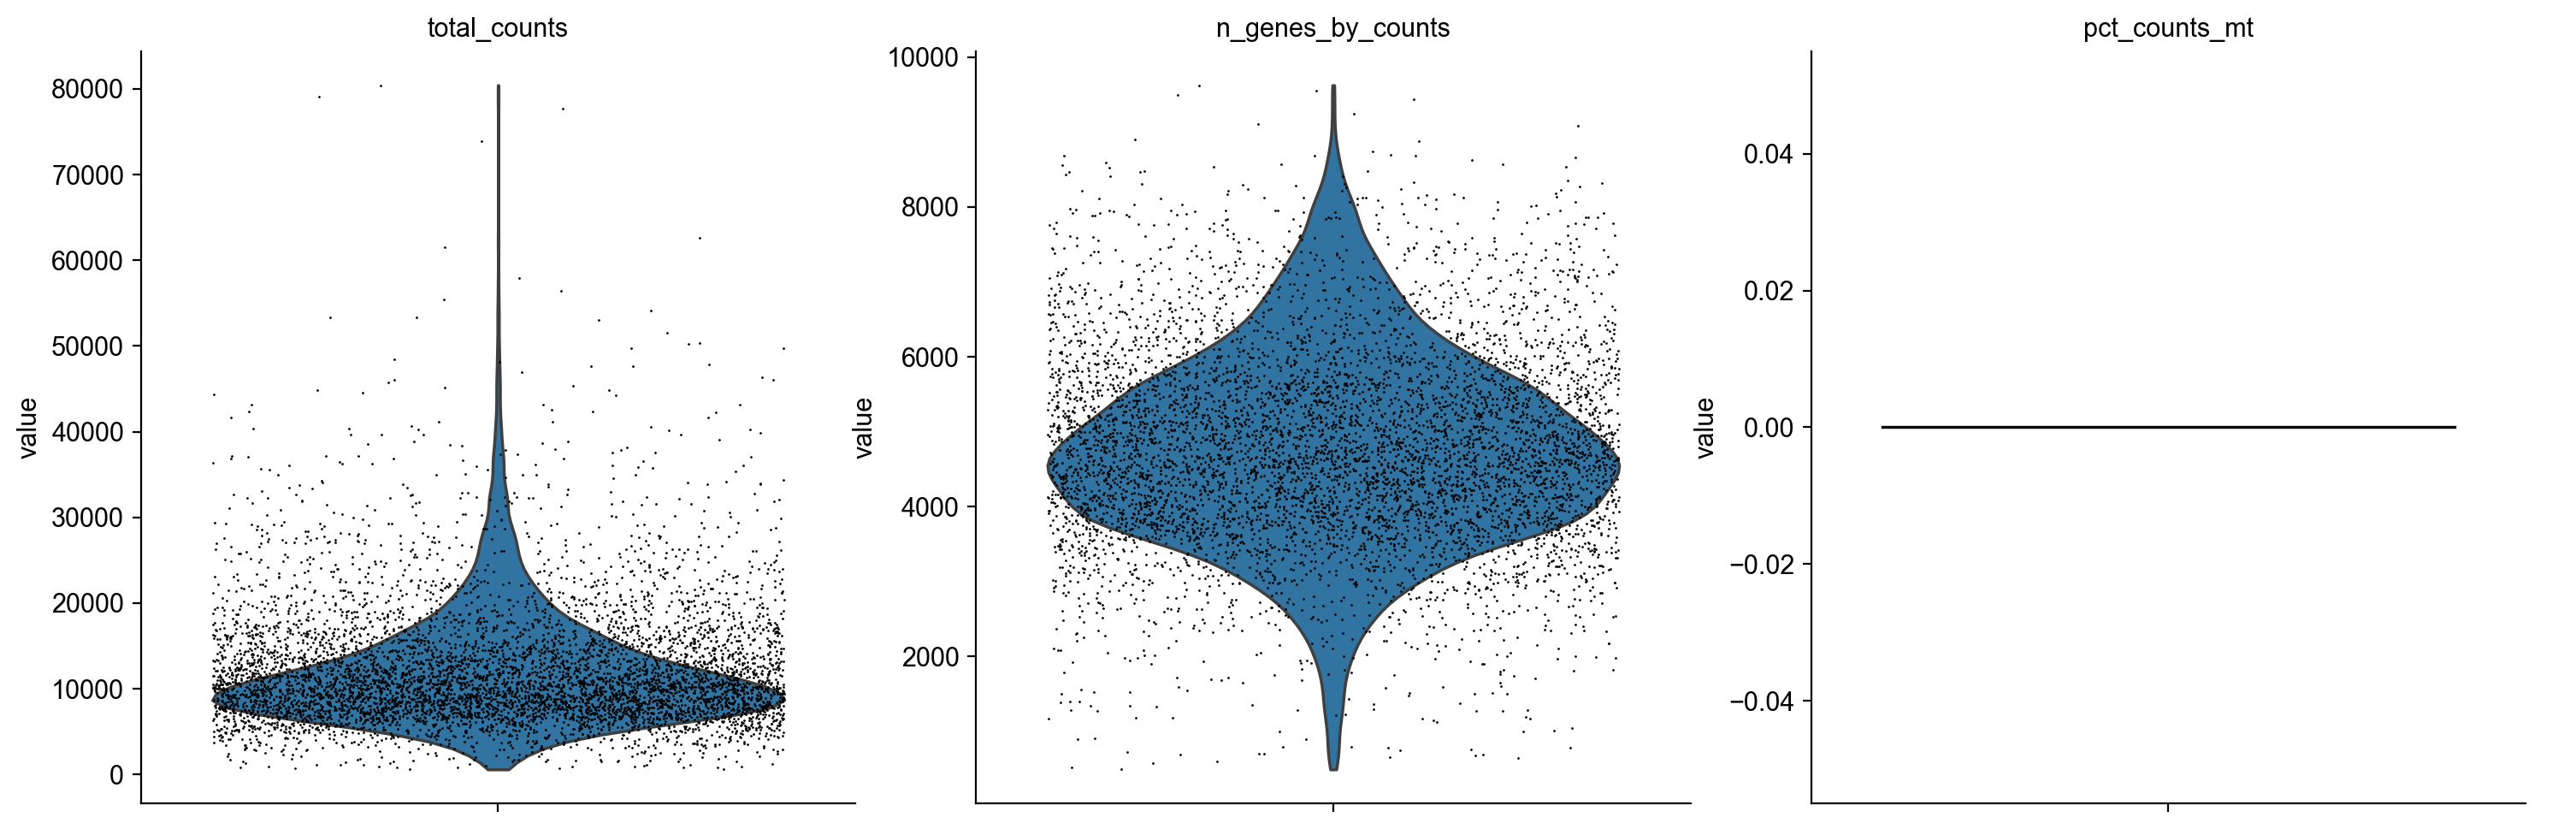

In [15]:
sc.pl.violin(
    adata,
    ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True,
)

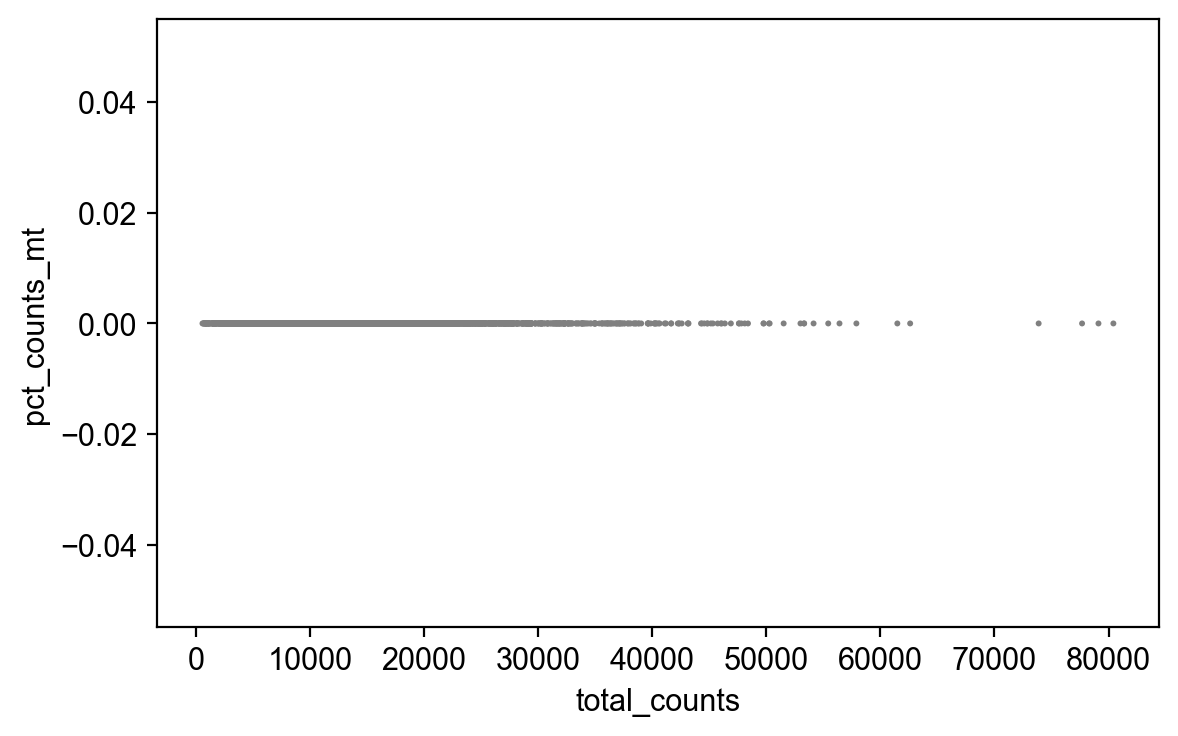

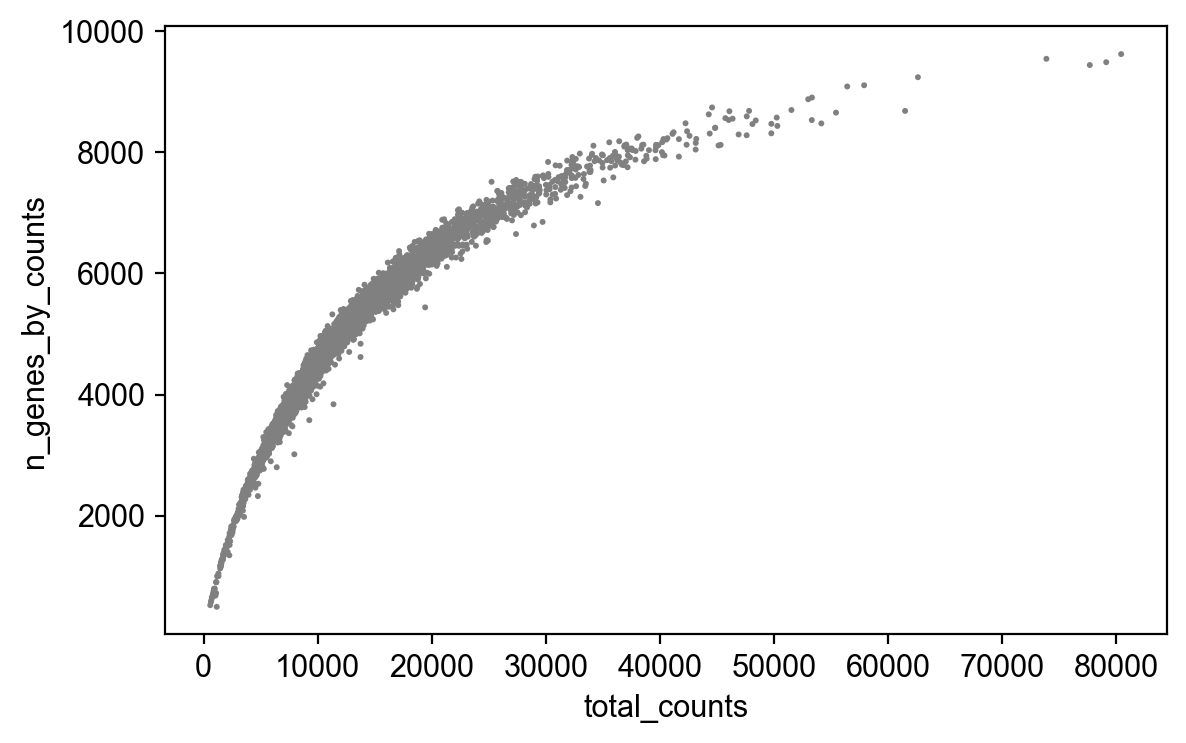

In [16]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [17]:
# Adjust QC thresholds based on the plots
adata = adata[
    (adata.obs['total_counts'] > 5000) &          # Minimum total counts
    (adata.obs['total_counts'] < 40000) &         # Maximum total counts
    (adata.obs['n_genes_by_counts'] > 500) &      # Minimum genes per cell
    (adata.obs['n_genes_by_counts'] < 7500)       # Maximum genes per cell (to exclude doublets)
]

# Filter genes detected in very few cells
adata = adata[:, adata.var['n_cells_by_counts'] > 10]

# not required now due to no mt genes
# adata = adata[adata.obs.pct_counts_mt < 15, :].copy()

# Normalization and Log Transformation

In [18]:
# Normalize total counts per cell to 10,000
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmic transformation
sc.pp.log1p(adata)

In [19]:
adata.X

<6001x13377 sparse matrix of type '<class 'numpy.float32'>'
	with 29023980 stored elements in Compressed Sparse Row format>

In [20]:
adata.var_names

Index(['NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1', 'HES4', 'ISG15', 'AGRN',
       'RNF223', 'C1orf159', 'TTLL10',
       ...
       'MT-ND2', 'MT-CO2', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4',
       'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object', length=13377)

# HVGs

In [21]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False)

# Dimensionality Reduction

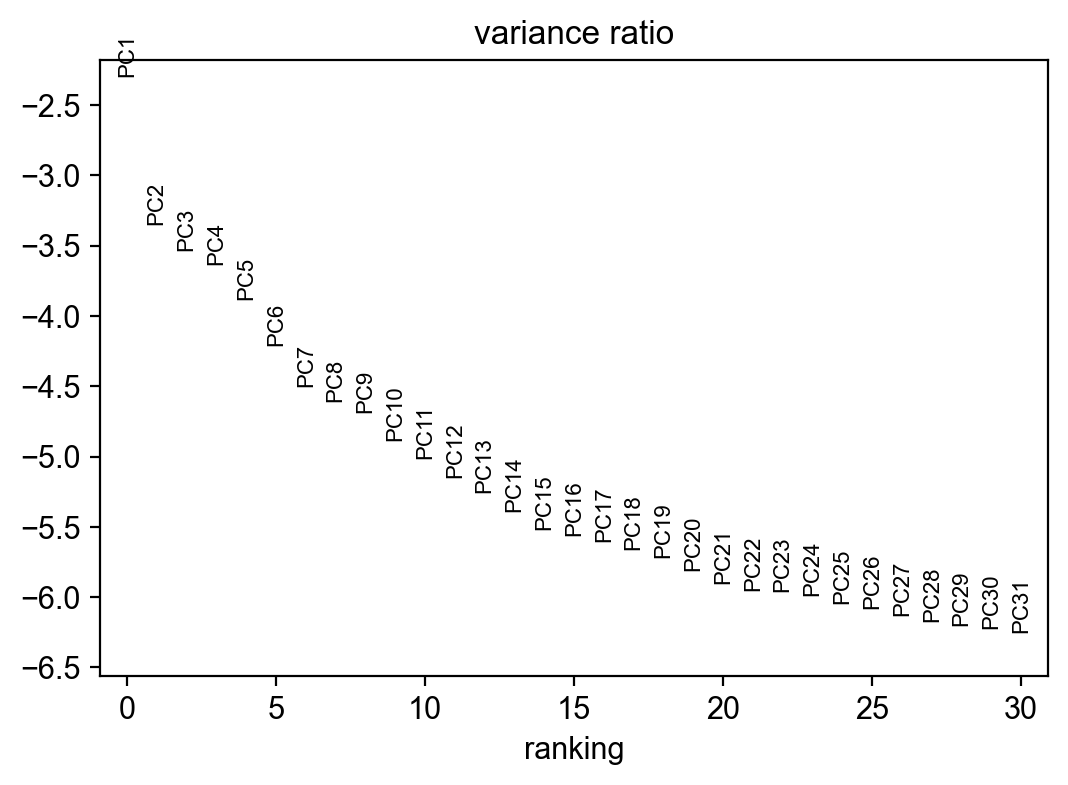

In [22]:
# Perform PCA
sc.tl.pca(adata, svd_solver='arpack')

# Visualize PCA
sc.pl.pca_variance_ratio(adata, log=True)

# Neighbors and Clustering

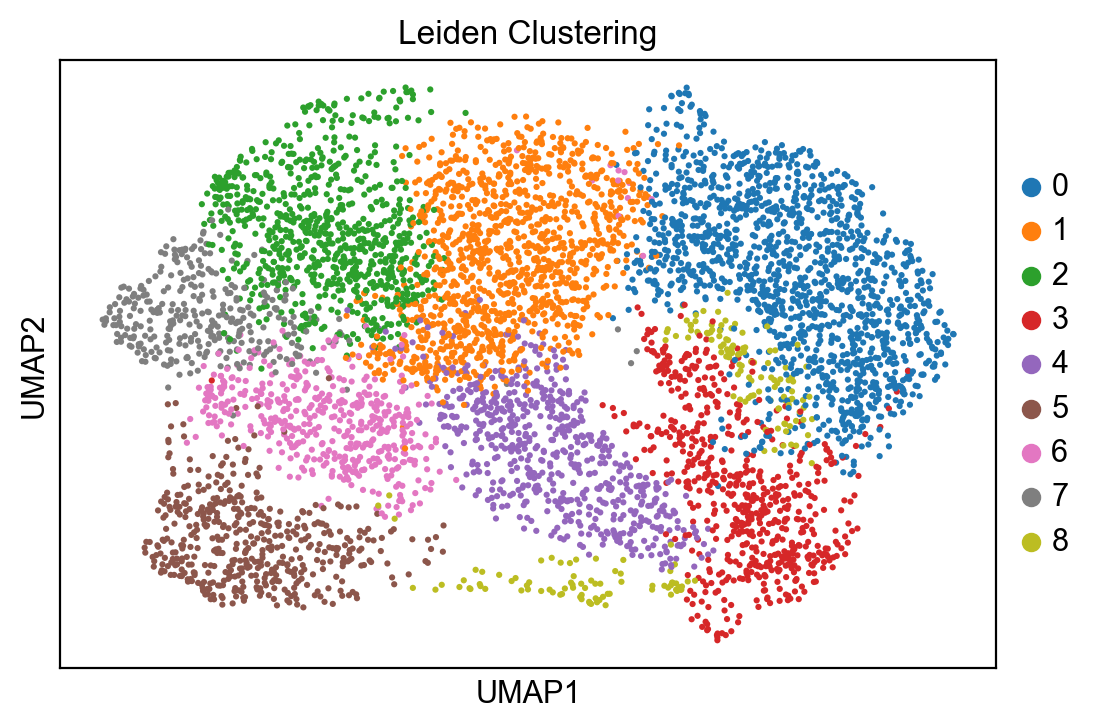

In [23]:
# Perform clustering (adjust resolution as needed)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15)
sc.tl.leiden(adata, resolution=0.5)

# Compute UMAP coordinates
sc.tl.umap(adata)

# Visualize clusters
sc.pl.umap(adata, color=['leiden'], title='Leiden Clustering', save="_Leiden_Clustering.png") 

In [24]:
adata

AnnData object with n_obs × n_vars = 6001 × 13377
    obs: 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

# scVelo Starts here

In [25]:
scv.pp.filter_and_normalize(adata)

Normalized count data: spliced, unspliced.
Logarithmized X.


/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


In [26]:
scv.pp.moments(adata)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [27]:
scv.tl.velocity(adata)

computing velocities
The correlation threshold has been reduced to 0.0.
Please be cautious when interpreting results.
    finished (0:00:07) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


In [28]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site

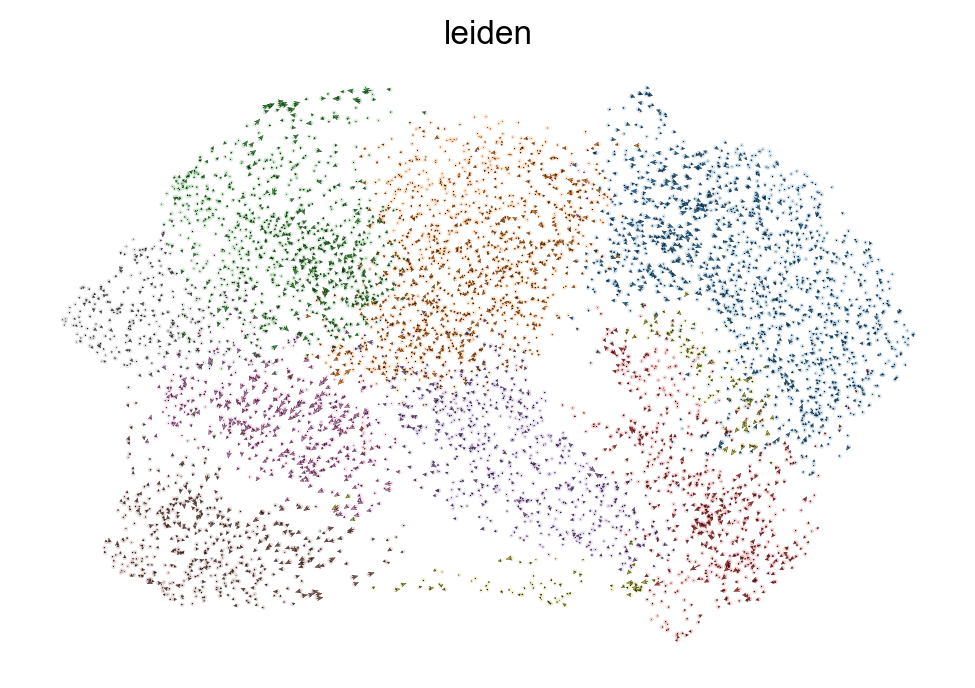

In [29]:
scv.pl.velocity_embedding(adata, basis='umap', color='leiden')

/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/vishragh/miniconda3/envs/velo/lib/python3.9/site

saving figure to file ../figures/scvelo_velo_plot.png


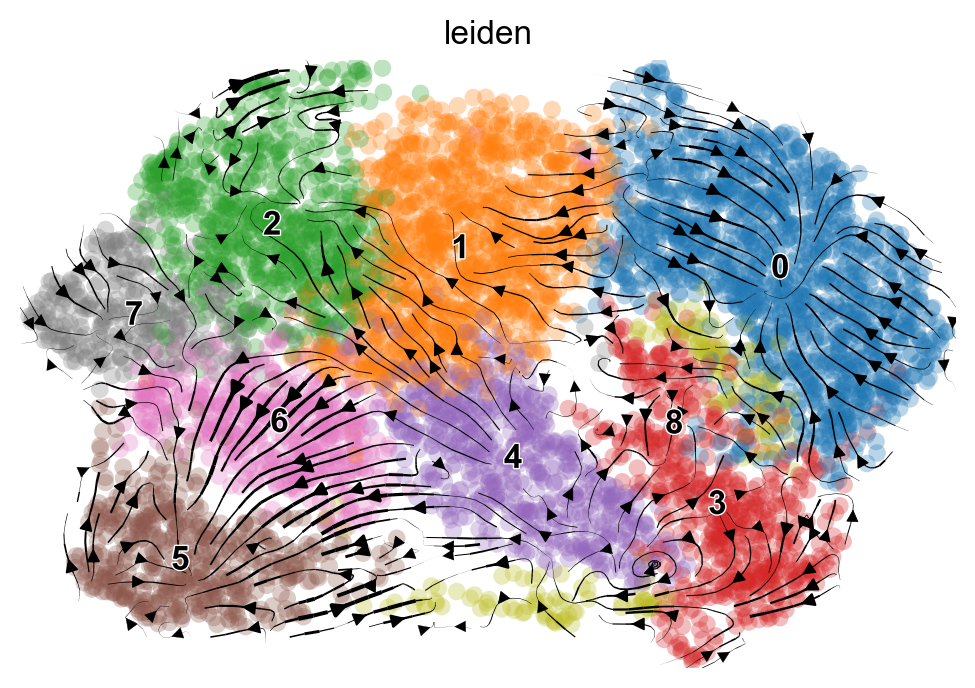

In [34]:
scv.pl.velocity_embedding_stream(adata, basis = 'umap', color = 'leiden', save='velo_plot.png')

saving figure to file ../figures/scvelo_phase_portrait.png


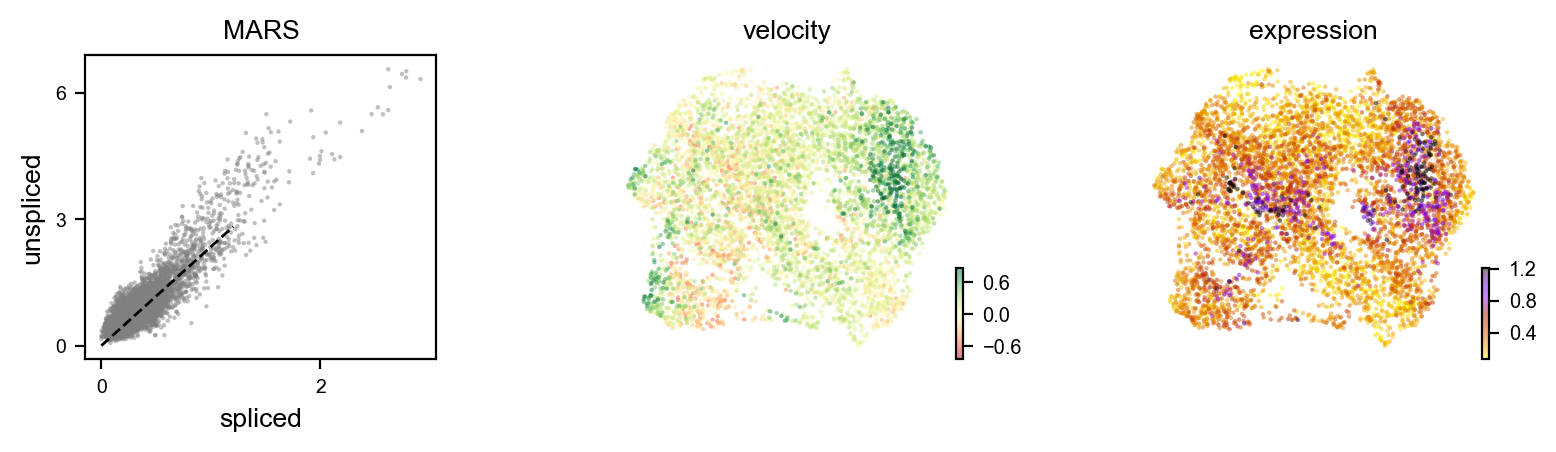

In [35]:
# Phase portrait
scv.pl.velocity(adata, var_names=['MARS'], save='phase_portrait.png')

saving figure to file ../figures/scvelo_proportions_.png


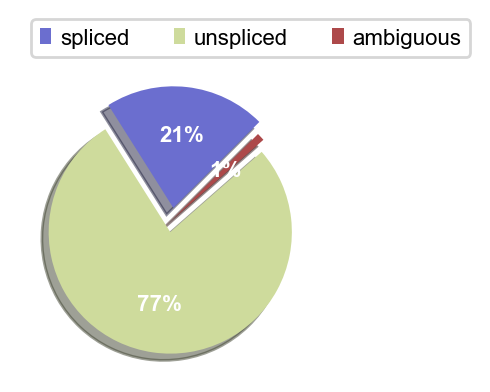

In [39]:
scv.pl.proportions(adata, save=".png")